In [9]:
# machine learning modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv1D, Conv1DTranspose
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping
# Visualization of data
import matplotlib.pyplot as plt

import random as rand
import os
import mne
import math
import scipy

import numpy as np

In [2]:
# function to make a signal have the desired SNR
# Source: https://sites.ualberta.ca/~msacchi/SNR_Def.pdf
def Add_Noise(s, SNR):
    # Compute d = s + n such that SNR = Ps/Pn
    #
    # s: Input signal
    # SNR: Desired signal-to-noise ratio
    # d: Output signal
    n = np.array(rand.sample(range(len(s)),k=len(s))).astype(float)
    Es = sum(np.square(s[:]))
    En = sum(np.square(n[:]))
    alpha = float(math.sqrt(Es/(SNR*En)))
    d = s+alpha*n
    return d,alpha*(n.astype(float))


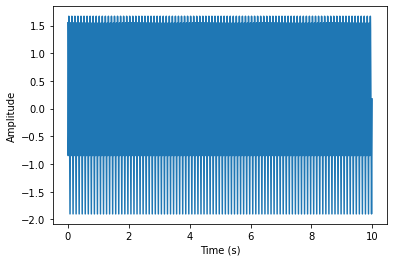

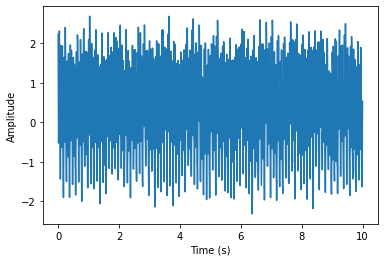

In [3]:
# Generate a complex MEG signal
sampling_rate = 150
t = np.arange(0,10, 1/sampling_rate)
signal = (np.sin(2 * np.pi * 10 * t) +
          np.cos(2 * np.pi * 20 * t + np.pi/4) +
          0.5 * np.sin(2 * np.pi * 30 * t + np.pi/2) +
          0.3 * np.cos(2 * np.pi * 40 * t - np.pi/3) +
          0.2 * np.sin(2 * np.pi * 50 * t + np.pi/6) +
          0.1 * np.cos(2 * np.pi * 60 * t - np.pi/8))
          
# Add some noise
noise_y,other = Add_Noise(signal,10)

# Add a heartbeat artifact
heart_rate = 1.2  # beats per second
heart_period = int(1 / heart_rate / (t[1] - t[0]))
heart_amplitude = 0.2
heart_signal = np.zeros_like(signal)
for i in range(heart_period, len(t), heart_period):
    heart_signal[i:i+heart_period] = heart_amplitude * np.sin(2 * np.pi * heart_rate * t[i:i+heart_period])


# Add rhythmic spikes
spike_frequency = 5
spike_amplitude = 0.3
spike_signal = spike_amplitude * np.sin(2 * np.pi * spike_frequency * t)

noise_signal = noise_y + heart_signal + spike_signal + np.random.normal(scale=0.1, size=len(t))

# Plot the MEG signal
plt.plot(t, signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()
# Plot the MEG signal with eyeblink artifact
plt.plot(t, noise_signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [6]:
num_of_samples = 20000
# Containers for samples.
n_samples = []
c_samples = []
x_s = []
y_s = [] # array of y values

for j in range(0,num_of_samples):
    for i in range(0,len(t)):
        x_s.append(t[i])
        y_s.append(noise_signal[i])
        
    # Append to noisy Samples
    n_samples.append((x_s,y_s))
    
    x_s = [] # clear array
    y_s = [] # clear array 
    
    for k in range(0,len(t)):
        x_s.append(t[k])
        y_s.append(signal[k])
        
    # Append to clean Samples
    c_samples.append((x_s,y_s))
    
    x_s = [] # clear array
    y_s = [] # clear array
    


In [7]:
print("Going to next computations...\n")
n_samples = np.array(n_samples)
c_samples = np.array(c_samples)

x_val_noisy, y_val_noisy = n_samples[:,0], n_samples[:,1]
x_val_pure, y_val_pure = c_samples[:,0], c_samples[:,1]

# Reshape Data and utilize Binary Cross Entropy
np.seterr(invalid='ignore')
y_val_noisy_r = []
y_val_pure_r = []
for i in range(0, len(y_val_noisy)):
    noisy_sample = y_val_noisy[i]
    pure_sample = y_val_pure[i]
    noisy_sample = np.nan_to_num((noisy_sample - np.min(noisy_sample)) / (np.max(noisy_sample) - np.min(noisy_sample)))
    pure_sample = np.nan_to_num((pure_sample - np.min(pure_sample)) / (np.max(pure_sample) - np.min(pure_sample)))
    y_val_noisy_r.append(noisy_sample)
    y_val_pure_r.append(pure_sample)
    
y_val_noisy_r   = np.array(y_val_noisy_r)
y_val_pure_r    = np.array(y_val_pure_r)
noisy_input     = y_val_noisy_r.reshape((y_val_noisy_r.shape[0], y_val_noisy_r.shape[1], 1))
pure_input      = y_val_pure_r.reshape((y_val_pure_r.shape[0], y_val_pure_r.shape[1], 1))  

Going to next computations...



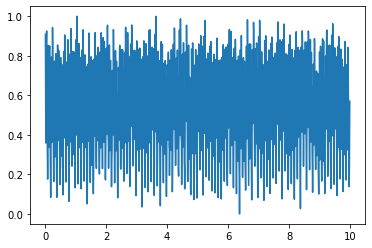

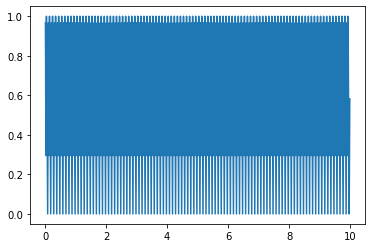

In [11]:
plt.plot(t, noisy_input[0])
plt.show()
plt.plot(t, pure_input[0])
plt.show()

In [12]:
# Model Configuration
input_shape = (1500,1)
batch_size = 120
no_epochs = 10
train_test_split = 0.3
validation_split = 0.3
verbosity = 1
max_norm_value = 2.0

# Create the model
model = Sequential()
model.add(Conv1D(256, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model.add(Conv1D(64, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1D(32, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1D(16, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(16, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(32, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(64, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(256, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1D(1, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='sigmoid', padding='same'))

print(model.summary())
# Train/test split
percentage_training = math.floor((1 - train_test_split) * len(noisy_input))
noisy_input, noisy_input_test = noisy_input[:percentage_training], noisy_input[percentage_training:]
pure_input, pure_input_test = pure_input[:percentage_training], pure_input[percentage_training:]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1498, 256)         1024      
                                                                 
 conv1d_1 (Conv1D)           (None, 1496, 64)          49216     
                                                                 
 conv1d_2 (Conv1D)           (None, 1494, 32)          6176      
                                                                 
 conv1d_3 (Conv1D)           (None, 1492, 16)          1552      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 1494, 16)         784       
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 1496, 32)         1568      
 ranspose)                                              

In [13]:
callback = EarlyStopping(monitor='val_loss', patience = 2)

# Compile and fit data
model.compile(optimizer='adam', loss='binary_crossentropy')
history = model.fit(noisy_input, pure_input,
                epochs=no_epochs,
                batch_size=batch_size,
                callbacks = [callback],
                validation_split=validation_split)

Epoch 1/10
82/82 [==============================] - 203s 2s/step - loss: 0.4800 - val_loss: 0.4628
Epoch 2/10
82/82 [==============================] - 216s 3s/step - loss: 0.4621 - val_loss: 0.4616
Epoch 3/10
82/82 [==============================] - 208s 3s/step - loss: 0.4614 - val_loss: 0.4613
Epoch 4/10
82/82 [==============================] - 212s 3s/step - loss: 0.4612 - val_loss: 0.4611
Epoch 5/10
82/82 [==============================] - 201s 2s/step - loss: 0.4613 - val_loss: 0.4611
Epoch 6/10
82/82 [==============================] - 189s 2s/step - loss: 0.4610 - val_loss: 0.4610
Epoch 7/10
82/82 [==============================] - 194s 2s/step - loss: 0.4611 - val_loss: 0.4610
Epoch 8/10
82/82 [==============================] - 191s 2s/step - loss: 0.4611 - val_loss: 0.4610
Epoch 9/10
82/82 [==============================] - 193s 2s/step - loss: 0.4611 - val_loss: 0.4610
Epoch 10/10
82/82 [==============================] - 191s 2s/step - loss: 0.4610 - val_loss: 0.4610


dict_keys(['loss', 'val_loss'])


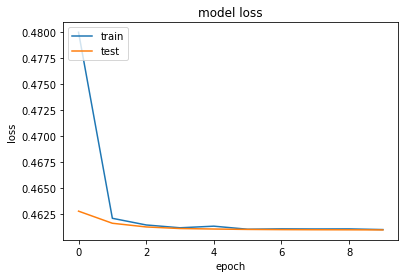

In [15]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 64ms/step


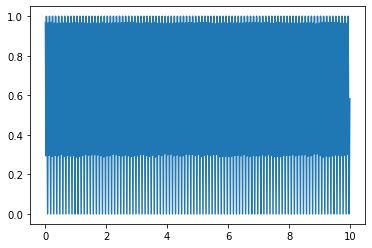

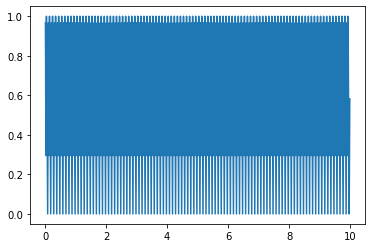

In [19]:
# Generate reconstruction
samples = noisy_input_test[:1]
reconstruction = model.predict(samples)


plt.plot(t, reconstruction[0])
plt.show()
plt.plot(t, pure_input[0])
plt.show()

In [20]:
noise = noisy_input[0] - pure_input[0]
r = np.abs(noise)**2
r = np.sum(r)
signal = np.sum(np.abs(pure_input[0])**2)
SNR = 10 * math.log10(signal/r)
print(SNR)

14.951608491528392


In [21]:
noise = reconstruction - pure_input[0]
r = np.abs(noise)**2
r = np.sum(r)
signal = np.sum(np.abs(pure_input[0])**2)
SNR = 10 * math.log10(signal/r)
print(SNR)

44.852064993633874


In [22]:
# serialize model to JSON
model_json = model.to_json()
with open("model_three.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_three.h5")
print("Saved model to disk")

Saved model to disk
